# Unit15_Example | Mining Flotation Process - DNN 預測矽石濃度

本 Notebook 展示如何使用 DNN 模型預測礦業浮選過程中的矽石濃度（% Silica Concentrate）。

**資料集**：Mining Process Flotation Plant Database  
**來源**：https://www.kaggle.com/datasets/edumagalhaes/quality-prediction-in-a-mining-process

**目標**：預測 `% Silica Concentrate`（越低越好）

---
### 0.環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P4_Unit15_Example_Mining'
SOURCE_DATA_DIR = 'mining'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_4' / 'Unit15'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\data\mining
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Mining
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Mining\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Mining\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


### 數據下載

In [2]:
# 數據來源: Kaggle Quality Prediction in a Mining Process
# https://www.kaggle.com/api/v1/datasets/download/edumagalhaes/quality-prediction-in-a-mining-process

import requests
import os
import zipfile

# 1. 設定路徑與 URL
url = "https://www.kaggle.com/api/v1/datasets/download/edumagalhaes/quality-prediction-in-a-mining-process"
zip_path = os.path.join(DATA_DIR, "quality-prediction-in-a-mining-process.zip")
data_file = os.path.join(DATA_DIR, "MiningProcess_Flotation_Plant_Database.csv")
extract_path = DATA_DIR

def download_and_extract():
    # --- 步驟 A: 下載檔案 ---
    print(f"正在從 {url} 下載...")
    try:
        # allow_redirects=True 處理 Kaggle 的重導向
        response = requests.get(url, allow_redirects=True, stream=True)
        response.raise_for_status() # 若下載失敗會拋出異常
        
        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"下載成功，檔案儲存於: {zip_path}")

        # --- 步驟 B: 解壓縮檔案 ---
        if zipfile.is_zipfile(zip_path):
            print(f"正在解壓縮至: {extract_path}...")
            # 確保目標資料夾存在
            if not os.path.exists(extract_path):
                os.makedirs(extract_path)
            
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            
            print("解壓縮完成！")
            
            # (選填) 步驟 C: 刪除原始 ZIP 檔以節省空間
            # os.remove(zip_path)
            # print("已移除原始 ZIP 壓縮檔。")
        else:
            print("錯誤：下載的檔案不是有效的 ZIP 格式。")
            
    except Exception as e:
        print(f"發生錯誤: {e}")

if __name__ == "__main__" and not os.path.exists(data_file):
    download_and_extract()
else:
    print(f"檔案已存在於: {data_file}")

正在從 https://www.kaggle.com/api/v1/datasets/download/edumagalhaes/quality-prediction-in-a-mining-process 下載...
下載成功，檔案儲存於: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\data\mining\quality-prediction-in-a-mining-process.zip
正在解壓縮至: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\data\mining...
解壓縮完成！


## 1. 環境設定與資料載入

In [3]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 機器學習套件
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# 深度學習套件
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks

# 設定隨機種子
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 設定繪圖風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.10.1
Keras version: 2.10.0


### 修正數據原有問題

In [4]:
# 讀取資料（注意：使用逗號作為小數點）
data_path = DATA_DIR / 'MiningProcess_Flotation_Plant_Database.csv'

df = pd.read_csv(data_path, decimal=',', parse_dates=['date'])

print(f"資料形狀：{df.shape}")
print(f"\n欄位列表：")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

資料形狀：(737453, 24)

欄位列表：
 1. date
 2. % Iron Feed
 3. % Silica Feed
 4. Starch Flow
 5. Amina Flow
 6. Ore Pulp Flow
 7. Ore Pulp pH
 8. Ore Pulp Density
 9. Flotation Column 01 Air Flow
10. Flotation Column 02 Air Flow
11. Flotation Column 03 Air Flow
12. Flotation Column 04 Air Flow
13. Flotation Column 05 Air Flow
14. Flotation Column 06 Air Flow
15. Flotation Column 07 Air Flow
16. Flotation Column 01 Level
17. Flotation Column 02 Level
18. Flotation Column 03 Level
19. Flotation Column 04 Level
20. Flotation Column 05 Level
21. Flotation Column 06 Level
22. Flotation Column 07 Level
23. % Iron Concentrate
24. % Silica Concentrate


In [5]:
# get a series of unique hourly timestamps
hours = pd.Series(df['date'].unique())
hours.index = hours
len(hours)

4097

In [6]:
# create a date time index from the first to the last hour included in the date column
date_range = pd.date_range(start=df.iloc[0,0], end='2017-09-09 23:59:40', freq='20S')
# remove first couple observations consistent with the counts exploration above
date_range = date_range[6:]
date_range[-5:]

DatetimeIndex(['2017-09-09 23:58:20', '2017-09-09 23:58:40',
               '2017-09-09 23:59:00', '2017-09-09 23:59:20',
               '2017-09-09 23:59:40'],
              dtype='datetime64[ns]', freq='20s')

In [7]:
# create lists from both the hours series and the new datetime index
hours_list = hours.index.format()
print(hours_list[:5])
seconds_list = date_range.format()
print(seconds_list[:5])

['2017-03-10 01:00:00', '2017-03-10 02:00:00', '2017-03-10 03:00:00', '2017-03-10 04:00:00', '2017-03-10 05:00:00']
['2017-03-10 01:02:00', '2017-03-10 01:02:20', '2017-03-10 01:02:40', '2017-03-10 01:03:00', '2017-03-10 01:03:20']


In [8]:
# match the new datetime index to the hours series and only append the timestamps if the datea and hour match the hours list
new_index = []
for idx in seconds_list:
    if (idx[:13] + ':00:00') in hours_list:
        new_index.append(idx)

#remove the one missing interval within the hour which we found earlier using the counts
new_index.remove('2017-04-10 00:00:00')
new_index[-20:]

['2017-09-09 23:53:20',
 '2017-09-09 23:53:40',
 '2017-09-09 23:54:00',
 '2017-09-09 23:54:20',
 '2017-09-09 23:54:40',
 '2017-09-09 23:55:00',
 '2017-09-09 23:55:20',
 '2017-09-09 23:55:40',
 '2017-09-09 23:56:00',
 '2017-09-09 23:56:20',
 '2017-09-09 23:56:40',
 '2017-09-09 23:57:00',
 '2017-09-09 23:57:20',
 '2017-09-09 23:57:40',
 '2017-09-09 23:58:00',
 '2017-09-09 23:58:20',
 '2017-09-09 23:58:40',
 '2017-09-09 23:59:00',
 '2017-09-09 23:59:20',
 '2017-09-09 23:59:40']

In [9]:
df['index'] = new_index
df['index'] = pd.to_datetime(df['index'])
df.index = df['index']
df = df.loc[:, df.columns[:-1]]
df.rename(columns={'date': 'datetime hours'}, inplace=True)
df.head()

,datetime hours,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
index,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:02:00,2017-03-10 01:00:00,55.2,16.98,3019.53,557.434,395.713,10.0664,1.74,249.214,253.235,...,250.884,457.396,432.962,424.954,443.558,502.255,446.370,523.344,66.91,1.31
2017-03-10 01:02:20,2017-03-10 01:00:00,55.2,16.98,3024.41,563.965,397.383,10.0672,1.74,249.719,250.532,...,248.994,451.891,429.560,432.939,448.086,496.363,445.922,498.075,66.91,1.31
2017-03-10 01:02:40,2017-03-10 01:00:00,55.2,16.98,3043.46,568.054,399.668,10.0680,1.74,249.741,247.874,...,248.071,451.240,468.927,434.610,449.688,484.411,447.826,458.567,66.91,1.31
2017-03-10 01:03:00,2017-03-10 01:00:00,55.2,16.98,3047.36,568.665,397.939,10.0689,1.74,249.917,254.487,...,251.147,452.441,458.165,442.865,446.210,471.411,437.690,427.669,66.91,1.31
2017-03-10 01:03:20,2017-03-10 01:00:00,55.2,16.98,3033.69,558.167,400.254,10.0697,1.74,250.203,252.136,...,248.928,452.441,452.900,450.523,453.670,462.598,443.682,425.679,66.91,1.31


In [10]:
# Resample data
df = df.resample('10T').mean()
df.shape

# 檢視前幾筆資料
df.head()

,datetime hours,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
index,,,,,,,,,,,,,,,,,,,,,
2017-03-10 01:00:00,2017-03-10 01:00:00,55.2,16.98,3361.057500,563.118042,395.874042,10.075875,1.740000,249.890542,250.317000,...,249.804375,448.652208,444.109250,448.166792,445.431792,451.509917,448.441583,448.905000,66.91,1.31
2017-03-10 01:10:00,2017-03-10 01:00:00,55.2,16.98,3357.252667,580.125967,399.862200,10.108153,1.740217,253.958333,250.900067,...,250.989300,453.864967,451.935517,448.745867,453.631000,450.584633,458.917167,460.637033,66.91,1.31
2017-03-10 01:20:00,2017-03-10 01:00:00,55.2,16.98,3070.661667,599.529933,401.349133,10.127283,1.746707,251.485100,250.411067,...,250.137867,452.494800,440.760867,452.886267,450.263700,465.369400,461.734333,446.147433,66.91,1.31
2017-03-10 01:30:00,2017-03-10 01:00:00,55.2,16.98,3164.459333,597.791267,398.358633,10.118313,1.741998,250.425067,250.066333,...,250.271100,449.258133,455.139800,450.352433,447.060233,454.305133,471.795400,453.887500,66.91,1.31
2017-03-10 01:40:00,2017-03-10 01:00:00,55.2,16.98,3079.379333,573.972533,398.469567,10.106127,1.723120,249.601400,249.710900,...,249.862700,450.544167,449.949767,449.099700,452.363400,459.419567,466.414133,445.955100,66.91,1.31


In [11]:
# 基本統計資訊
df.describe()

,datetime hours,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,...,Flotation Column 07 Air Flow,Flotation Column 01 Level,Flotation Column 02 Level,Flotation Column 03 Level,Flotation Column 04 Level,Flotation Column 05 Level,Flotation Column 06 Level,Flotation Column 07 Level,% Iron Concentrate,% Silica Concentrate
count,24582,24582.000000,24582.000000,24582.000000,24582.000000,24582.000000,24582.000000,24582.000000,24582.000000,24582.000000,...,24582.000000,24582.000000,24582.000000,24582.000000,24582.000000,24582.000000,24582.000000,24582.000000,24582.000000,24582.000000
mean,2017-06-16 03:26:05.828655104,56.294730,14.651733,2869.143416,488.145178,397.578358,9.767641,1.680380,280.151570,277.159711,...,290.754467,520.244348,522.649020,531.352080,420.321218,425.251952,429.941200,421.021496,65.050084,2.326754
min,2017-03-10 01:00:00,42.740000,1.310000,0.921166,242.219746,376.408622,8.753377,1.519835,175.790507,176.829815,...,186.481236,151.820872,211.608444,127.746289,162.573468,167.357390,170.251132,178.421492,62.050000,0.600000
25%,2017-05-04 23:00:00,52.670000,8.940000,2104.073947,432.693975,397.461819,9.527912,1.647141,250.146942,250.148533,...,284.039231,404.287775,447.770183,402.310675,352.702392,352.770517,354.185017,352.601292,64.370000,1.440000
50%,2017-06-16 15:00:00,56.080000,13.850000,2915.378167,503.502900,399.644600,9.797886,1.697020,299.720017,299.160883,...,299.786933,498.662300,499.247283,498.900017,402.691967,402.893167,406.729850,402.625917,65.210000,2.000000
75%,2017-07-29 07:00:00,59.720000,19.600000,3632.413083,553.174942,401.229383,10.037983,1.727706,300.001158,300.085258,...,300.335842,599.118867,598.804375,600.321200,493.724663,494.800808,496.230908,474.854850,65.860000,3.010000
max,2017-09-09 23:00:00,65.780000,33.400000,6291.075047,739.094182,418.562891,10.807744,1.852895,360.405503,316.196033,...,355.407967,861.700722,828.457250,886.790571,679.099255,674.936910,698.601644,657.743296,68.010000,5.530000
std,NaN,5.157822,6.807544,1069.480489,88.885242,8.981687,0.386522,0.068437,29.578388,29.602285,...,27.446740,127.243159,123.022033,146.671433,81.937289,78.320428,77.383318,75.558373,1.118655,1.125550


## 2. 資料預處理

In [12]:
# 檢查缺失值
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_pct
})

print("缺失值統計：")
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))
print(f"\n總缺失值數量：{missing_counts.sum()}")

缺失值統計：
                              Missing Count  Percentage
datetime hours                         1908    7.202718
% Iron Feed                            1908    7.202718
% Iron Concentrate                     1908    7.202718
Flotation Column 07 Level              1908    7.202718
Flotation Column 06 Level              1908    7.202718
Flotation Column 05 Level              1908    7.202718
Flotation Column 04 Level              1908    7.202718
Flotation Column 03 Level              1908    7.202718
Flotation Column 02 Level              1908    7.202718
Flotation Column 01 Level              1908    7.202718
Flotation Column 07 Air Flow           1908    7.202718
Flotation Column 06 Air Flow           1908    7.202718
Flotation Column 05 Air Flow           1908    7.202718
Flotation Column 04 Air Flow           1908    7.202718
Flotation Column 03 Air Flow           1908    7.202718
Flotation Column 02 Air Flow           1908    7.202718
Flotation Column 01 Air Flow           19

In [13]:
# 處理缺失值
# 1. 刪除目標變數缺失的樣本
df_clean = df.dropna(subset=['% Silica Concentrate']).copy()
print(f"刪除目標變數缺失後：{df_clean.shape}")

# 2. 對特徵變數進行前向填充
feature_cols = [col for col in df_clean.columns if col not in ['date', '% Silica Concentrate']]
df_clean[feature_cols] = df_clean[feature_cols].fillna(method='ffill')

# 3. 若仍有缺失，使用均值填充
df_clean[feature_cols] = df_clean[feature_cols].fillna(df_clean[feature_cols].mean())

print(f"\n處理後缺失值：{df_clean.isnull().sum().sum()}")
print(f"最終資料形狀：{df_clean.shape}")
df_clean.to_csv(DATA_DIR/'Mining.csv')

刪除目標變數缺失後：(24582, 24)

處理後缺失值：0
最終資料形狀：(24582, 24)


In [14]:
# 分離特徵與目標
# 移除 date 和兩個目標變數
# df_clean.reset_index(inplace=True)

X = df_clean.drop(['datetime hours', '% Iron Concentrate', '% Silica Concentrate'], axis=1)
y = df_clean['% Silica Concentrate']

print(f"特徵矩陣 X: {X.shape}")
print(f"目標向量 y: {y.shape}")
print(f"\n特徵列表：")
for i, col in enumerate(X.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\n目標向量 y:")
print(y.name)

特徵矩陣 X: (24582, 21)
目標向量 y: (24582,)

特徵列表：
 1. % Iron Feed
 2. % Silica Feed
 3. Starch Flow
 4. Amina Flow
 5. Ore Pulp Flow
 6. Ore Pulp pH
 7. Ore Pulp Density
 8. Flotation Column 01 Air Flow
 9. Flotation Column 02 Air Flow
10. Flotation Column 03 Air Flow
11. Flotation Column 04 Air Flow
12. Flotation Column 05 Air Flow
13. Flotation Column 06 Air Flow
14. Flotation Column 07 Air Flow
15. Flotation Column 01 Level
16. Flotation Column 02 Level
17. Flotation Column 03 Level
18. Flotation Column 04 Level
19. Flotation Column 05 Level
20. Flotation Column 06 Level
21. Flotation Column 07 Level

目標向量 y:
% Silica Concentrate


## 3. EDA - 探索性資料分析

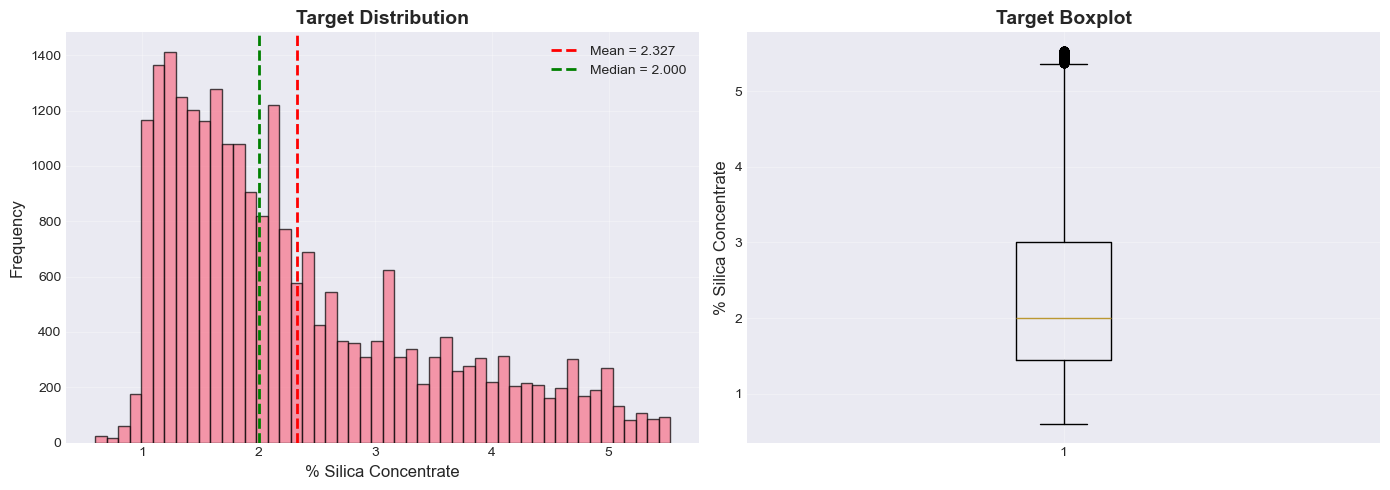

目標變數統計：
count    24582.000000
mean         2.326754
std          1.125550
min          0.600000
25%          1.440000
50%          2.000000
75%          3.010000
max          5.530000
Name: % Silica Concentrate, dtype: float64


In [15]:
# 目標變數分佈
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 直方圖
axes[0].hist(y, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(y.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean = {y.mean():.3f}')
axes[0].axvline(y.median(), color='green', linestyle='--', linewidth=2, label=f'Median = {y.median():.3f}')
axes[0].set_xlabel('% Silica Concentrate', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Target Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 箱型圖
axes[1].boxplot(y, vert=True)
axes[1].set_ylabel('% Silica Concentrate', fontsize=12)
axes[1].set_title('Target Boxplot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'target_hist.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"目標變數統計：")
print(y.describe())

In [16]:
# 相關性分析
corr_with_target = X.corrwith(y).sort_values(ascending=False)

print("特徵與目標的相關係數（前10強正相關）：")
print(corr_with_target.head(10))
print("\n特徵與目標的相關係數（前10強負相關）：")
print(corr_with_target.tail(10))

特徵與目標的相關係數（前10強正相關）：
Amina Flow                      0.160834
% Silica Feed                   0.072723
Ore Pulp Density                0.047532
Flotation Column 02 Level       0.032248
Flotation Column 01 Level       0.017735
Flotation Column 03 Level       0.014652
Ore Pulp Flow                   0.008889
Flotation Column 04 Air Flow   -0.005281
Flotation Column 05 Air Flow   -0.010062
Flotation Column 06 Air Flow   -0.050401
dtype: float64

特徵與目標的相關係數（前10強負相關）：
Starch Flow                    -0.075434
% Iron Feed                    -0.077052
Flotation Column 06 Level      -0.118971
Ore Pulp pH                    -0.147938
Flotation Column 07 Level      -0.158878
Flotation Column 04 Level      -0.167455
Flotation Column 02 Air Flow   -0.170484
Flotation Column 05 Level      -0.182610
Flotation Column 03 Air Flow   -0.219387
Flotation Column 01 Air Flow   -0.219475
dtype: float64


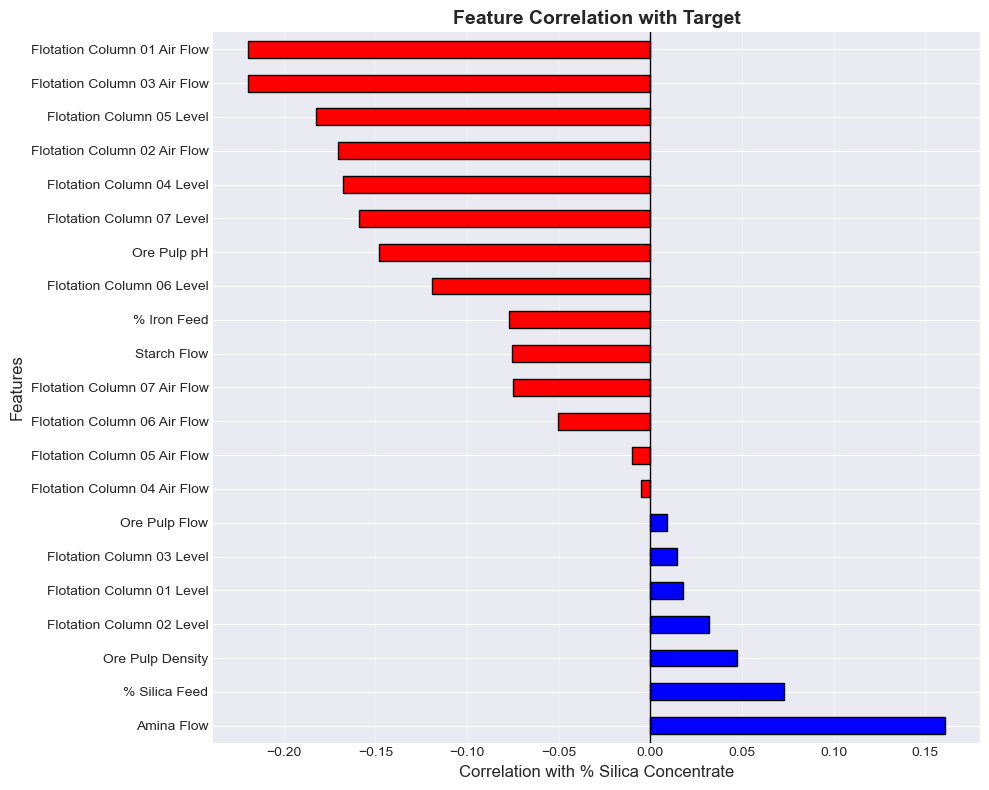

In [17]:
# 繪製相關性條形圖
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['red' if x < 0 else 'blue' for x in corr_with_target.values]
corr_with_target.plot(kind='barh', ax=ax, color=colors, edgecolor='black')

ax.set_xlabel('Correlation with % Silica Concentrate', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Feature Correlation with Target', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(FIG_DIR / 'corr_bar.png', dpi=300, bbox_inches='tight')
plt.show()

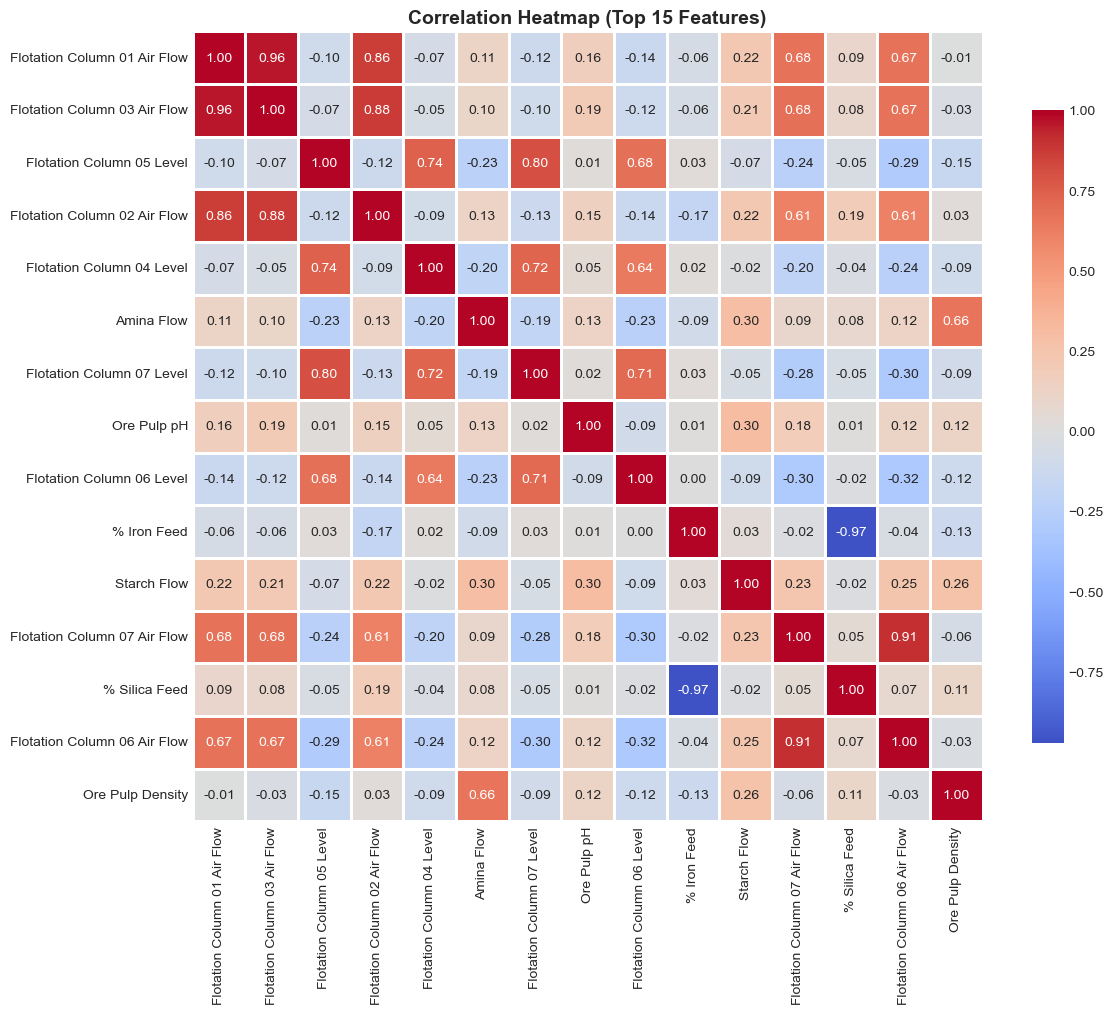

In [18]:
# 繪製相關性熱力圖（選擇前15個最相關的特徵）
top_features = corr_with_target.abs().nlargest(15).index.tolist()
corr_matrix = X[top_features].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Heatmap (Top 15 Features)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'corr_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### 加入滯後(Lag)


In [19]:
# 假設滯留時間約 1 小時，數據每 10 分鐘一筆
# 加入 lag 6 steps (60分鐘前內) 的資訊
X.columns
X_shift = X.copy()
for col in X.columns:
    # 建立 lag1 到 lag6
    for i in range(1, 7):
        X_shift[f'{col}_lag{i}'] = X[col].shift(i)

X_shift = X_shift.dropna()
print(X_shift.shape)
X_shift.head()

(24576, 147)


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 06 Level_lag3,Flotation Column 06 Level_lag4,Flotation Column 06 Level_lag5,Flotation Column 06 Level_lag6,Flotation Column 07 Level_lag1,Flotation Column 07 Level_lag2,Flotation Column 07 Level_lag3,Flotation Column 07 Level_lag4,Flotation Column 07 Level_lag5,Flotation Column 07 Level_lag6
index,,,,,,,,,,,,,,,,,,,,,
2017-03-10 02:00:00,55.2,16.98,3032.266667,529.127633,398.752433,10.151487,1.654127,249.477367,250.314600,250.062233,...,471.795400,461.734333,458.917167,448.441583,447.338867,445.955100,453.887500,446.147433,460.637033,448.905000
2017-03-10 02:10:00,55.2,16.98,2753.826000,504.113633,400.349933,10.182490,1.628891,249.462033,249.950133,250.103733,...,466.414133,471.795400,461.734333,458.917167,456.220467,447.338867,445.955100,453.887500,446.147433,460.637033
2017-03-10 02:20:00,55.2,16.98,2925.458000,525.015700,402.460267,10.169810,1.655257,250.186033,251.018667,250.068700,...,475.808900,466.414133,471.795400,461.734333,448.128600,456.220467,447.338867,445.955100,453.887500,446.147433
2017-03-10 02:30:00,55.2,16.98,3325.970000,544.487500,399.346200,10.108207,1.678155,251.292400,249.761267,250.027233,...,456.735900,475.808900,466.414133,471.795400,443.035200,448.128600,456.220467,447.338867,445.955100,453.887500
2017-03-10 02:40:00,55.2,16.98,3420.522333,557.817367,399.283300,10.078447,1.689968,250.006700,250.350767,249.941433,...,453.433900,456.735900,475.808900,466.414133,456.432200,443.035200,448.128600,456.220467,447.338867,445.955100


In [20]:
y2=y[y.index>=X_shift.index[0]]
print(y2.shape)
y2.head()

(24576,)


index
2017-03-10 02:00:00    1.11
2017-03-10 02:10:00    1.11
2017-03-10 02:20:00    1.11
2017-03-10 02:30:00    1.11
2017-03-10 02:40:00    1.11
Name: % Silica Concentrate, dtype: float64

In [21]:
# 後滯數據相關性分析
corr_with_target2 = X_shift.corrwith(y2).sort_values(ascending=False)

print("特徵與目標的相關係數（前10強正相關）：")
print(corr_with_target2.head(10))
print("\n特徵與目標的相關係數（前10強負相關）：")
print(corr_with_target2.tail(10))

特徵與目標的相關係數（前10強正相關）：
Amina Flow            0.161095
Amina Flow_lag1       0.156323
Amina Flow_lag2       0.151934
Amina Flow_lag3       0.148056
Amina Flow_lag4       0.144686
Amina Flow_lag5       0.141248
Amina Flow_lag6       0.137026
% Silica Feed         0.072807
% Silica Feed_lag1    0.071411
% Silica Feed_lag2    0.070004
dtype: float64

特徵與目標的相關係數（前10強負相關）：
Flotation Column 03 Air Flow_lag2   -0.220337
Flotation Column 03 Air Flow_lag3   -0.220448
Flotation Column 03 Air Flow_lag4   -0.220494
Flotation Column 03 Air Flow_lag5   -0.220627
Flotation Column 03 Air Flow_lag6   -0.220708
Flotation Column 01 Air Flow_lag2   -0.220716
Flotation Column 01 Air Flow_lag3   -0.220926
Flotation Column 01 Air Flow_lag4   -0.221082
Flotation Column 01 Air Flow_lag5   -0.221292
Flotation Column 01 Air Flow_lag6   -0.221422
dtype: float64


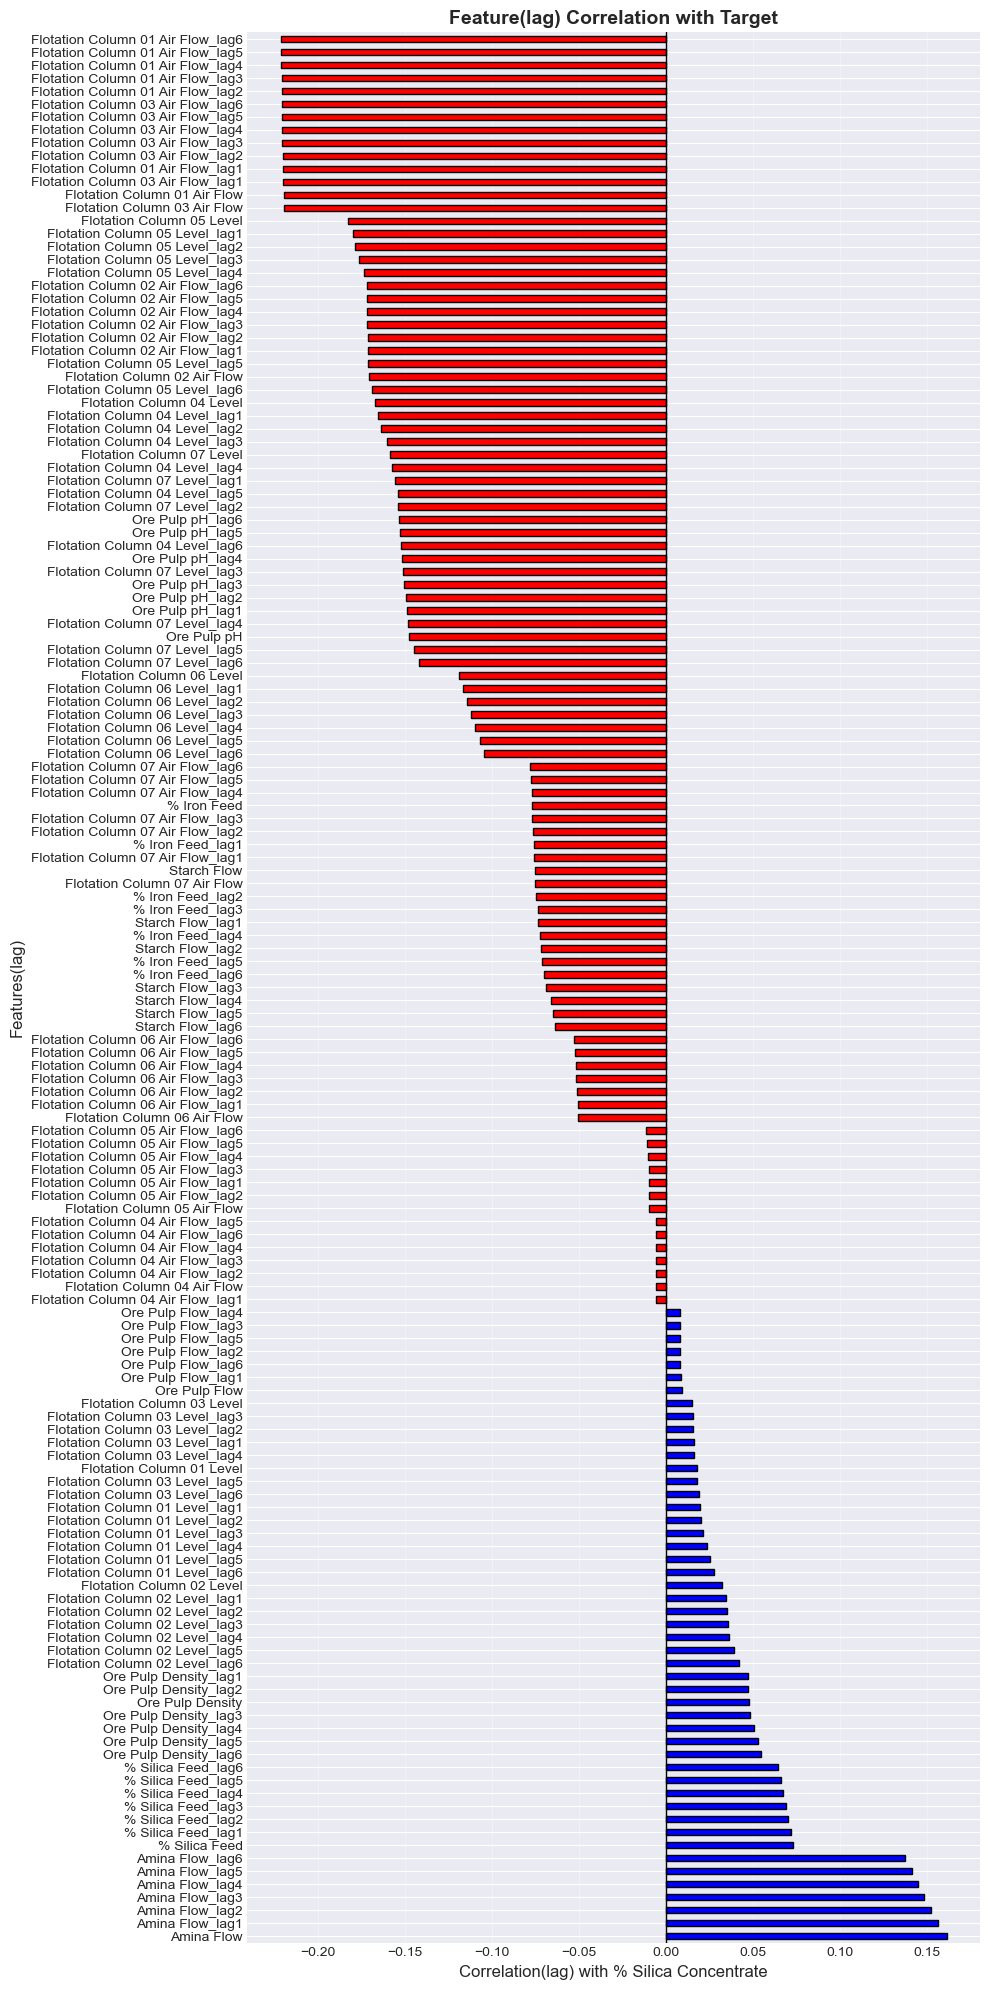

In [22]:
# 繪製相關性條形圖
fig, ax = plt.subplots(figsize=(10, 20))

colors = ['red' if x < 0 else 'blue' for x in corr_with_target2.values]
corr_with_target2.plot(kind='barh', ax=ax, color=colors, edgecolor='black')

ax.set_xlabel('Correlation(lag) with % Silica Concentrate', fontsize=12)
ax.set_ylabel('Features(lag)', fontsize=12)
ax.set_title('Feature(lag) Correlation with Target', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linewidth=1)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(FIG_DIR / 'corr_bar_lag.png', dpi=300, bbox_inches='tight')
plt.show()

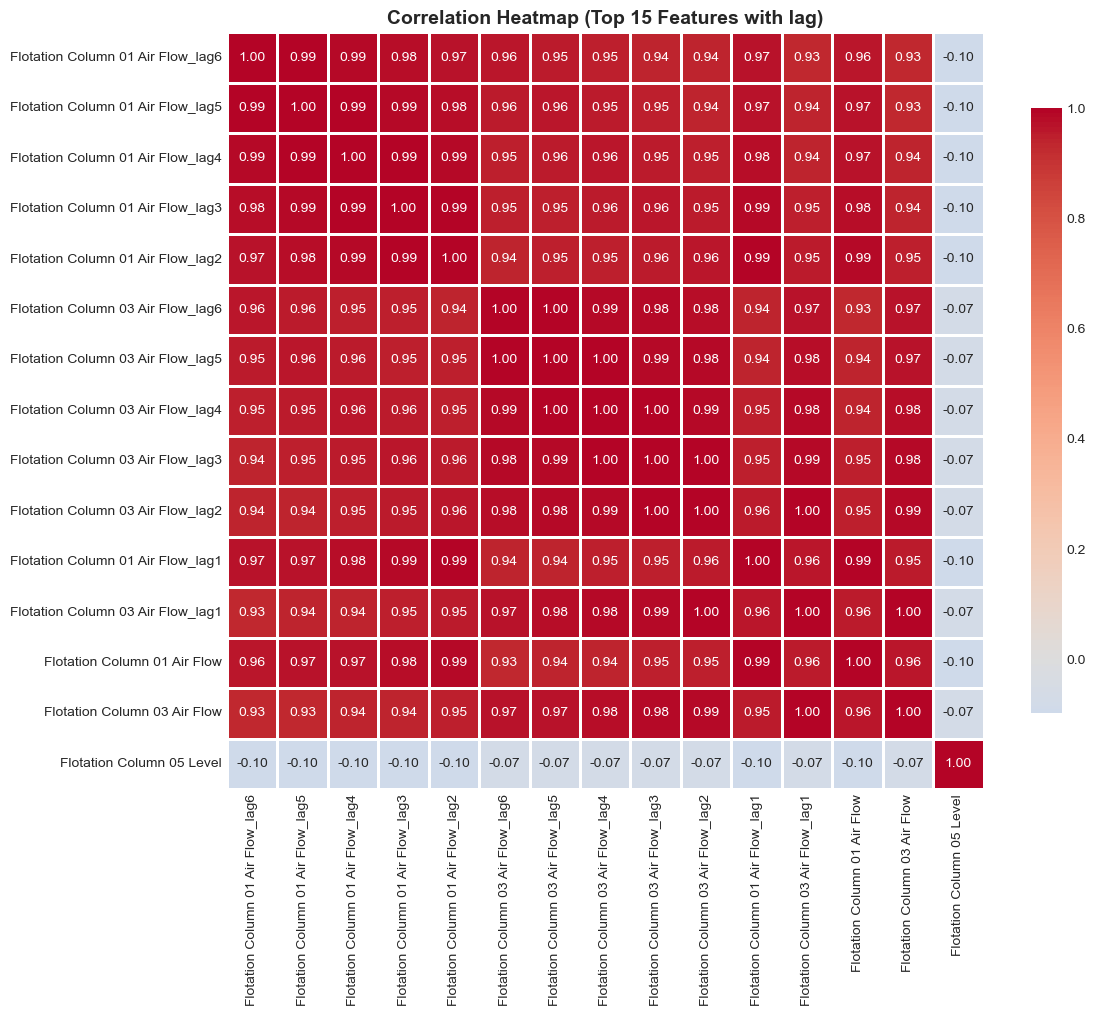

In [23]:
# 繪製相關性熱力圖（選擇前15個最相關的特徵）
top_features2 = corr_with_target2.abs().nlargest(15).index.tolist()
corr_matrix2 = X_shift[top_features2].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix2, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Heatmap (Top 15 Features with lag)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 'corr_heatmap_lag.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. 資料切分與標準化

In [24]:
# 資料切分：70% train, 15% valid, 15% test
# 第一次切分：分離 Train set (70%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_shift, y2, test_size=0.30, shuffle=True
)

# 第二次切分：從剩餘 30% 中分離 valid/test set (剩餘30%各一半)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, shuffle=True
)

print(f"訓練集：{X_train.shape}")
print(f"驗證集：{X_valid.shape}")
print(f"測試集：{X_test.shape}")

訓練集：(17203, 147)
驗證集：(3686, 147)
測試集：(3687, 147)


In [25]:
X_train.head()

,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,...,Flotation Column 06 Level_lag3,Flotation Column 06 Level_lag4,Flotation Column 06 Level_lag5,Flotation Column 06 Level_lag6,Flotation Column 07 Level_lag1,Flotation Column 07 Level_lag2,Flotation Column 07 Level_lag3,Flotation Column 07 Level_lag4,Flotation Column 07 Level_lag5,Flotation Column 07 Level_lag6
index,,,,,,,,,,,,,,,,,,,,,
2017-07-24 13:30:00,57.46,10.80,3723.179667,580.373233,398.539967,9.929967,1.701690,250.094367,250.411433,250.034467,...,497.322567,503.996700,500.147400,499.851733,501.103167,494.995867,499.271333,503.340400,496.986900,499.125733
2017-08-25 21:40:00,58.81,7.44,3293.506667,539.936133,380.576067,9.378744,1.687696,299.955867,299.443600,300.159667,...,380.445500,353.915833,369.896533,363.205833,346.179667,348.149533,355.350067,342.819333,360.123567,319.555367
2017-07-04 03:20:00,55.69,15.18,2487.063067,507.885667,396.538633,10.052993,1.621227,299.869533,300.861800,300.059567,...,403.498600,402.125100,401.772167,396.510633,399.788967,395.655367,401.667967,400.107400,401.804033,399.046100
2017-08-12 14:50:00,48.81,25.31,5195.130333,448.120100,415.206941,10.408383,1.681782,300.930300,299.908800,299.908100,...,353.385567,356.406633,349.449167,353.296933,351.240100,340.991767,357.089533,347.661367,352.248400,339.077033
2017-06-25 14:00:00,56.96,12.49,3873.814333,560.041767,399.881967,9.774460,1.681349,300.217567,300.352500,299.775433,...,464.752533,481.455833,477.964133,495.121700,506.208400,502.563567,490.577133,503.382067,505.100967,493.330000


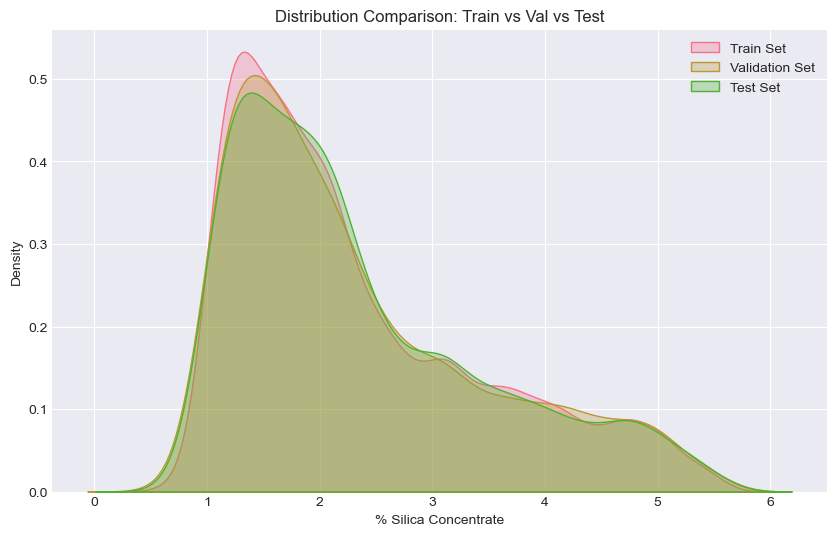

In [26]:
# 目標變數的分佈一致性 (Stratification) 確認
plt.figure(figsize=(10, 6))

# 繪製密度圖 (KDE) 來比較分佈形狀，而不是比較數量
sns.kdeplot(y_train, label='Train Set', fill=True, alpha=0.3)
sns.kdeplot(y_valid, label='Validation Set', fill=True, alpha=0.3)
sns.kdeplot(y_test, label='Test Set', fill=True, alpha=0.3)

plt.title('Distribution Comparison: Train vs Val vs Test')
plt.xlabel('% Silica Concentrate')
plt.legend()
plt.show()

In [27]:
# 標準化（只在訓練集上 fit）
# X 特徵標準化
scaler_X = StandardScaler()
scaler_X.fit(X_shift)

X_train_scaled = scaler_X.transform(X_train)
X_valid_scaled = scaler_X.transform(X_valid)
X_test_scaled = scaler_X.transform(X_test)

# y 目標變數標準化
scaler_y = StandardScaler()
scaler_y.fit(y2.values.reshape(-1, 1))
# y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).flatten()
# y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1)).flatten()
# y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
# y_train_scaled = np.log(y_train)
# y_valid_scaled = np.log(y_valid)
# y_test_scaled = np.log(y_test)



print("標準化完成！")
print(f"X 訓練集均值: {X_train_scaled.mean(axis=0)[:5]}")
print(f"X 訓練集標準差: {X_train_scaled.std(axis=0)[:5]}")
print(f"y 訓練集均值: {y_train.mean():.6f}")
print(f"y 訓練集標準差: {y_train.std():.6f}")

標準化完成！
X 訓練集均值: [-0.00419787  0.004391   -0.00195566 -0.00411193 -0.00260535]
X 訓練集標準差: [1.00039903 1.00032738 0.99955264 1.0007935  0.99739537]
y 訓練集均值: 2.323516
y 訓練集標準差: 1.123662


## 5. Baseline 模型：Random Forest Regressor

In [28]:
# 訓練 Random Forest（不需要標準化）

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

# load example model
LOAD_RF_MODEL = False
if LOAD_RF_MODEL:
    import joblib
    rf_model = joblib.load(MODEL_DIR / 'example_rf_model.joblib')
    print("\n載入 Random Forest 模型完成！")
else:
    print("訓練 Random Forest Baseline...")
    rf_model.fit(X_train_scaled, y_train)
    print("\nRandom Forest 訓練完成！")

訓練 Random Forest Baseline...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.



Random Forest 訓練完成！


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.7s finished


In [29]:
# Random Forest 預測與評估
def evaluate_model(y_true, y_pred, model_name="Model"):
    """評估回歸模型性能"""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{'='*50}")
    print(f"{model_name} - Performance Metrics")
    print(f"{'='*50}")
    print(f"MAE  : {mae:.6f}")
    print(f"RMSE : {rmse:.6f}")
    print(f"R²   : {r2:.6f}")
    print(f"{'='*50}")
    
    return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# 在各資料集上評估
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_valid_pred_rf = rf_model.predict(X_valid_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

rf_train_metrics = evaluate_model(y_train, y_train_pred_rf, "Random Forest - Train")
rf_valid_metrics = evaluate_model(y_valid, y_valid_pred_rf, "Random Forest - Valid")
rf_test_metrics = evaluate_model(y_test, y_test_pred_rf, "Random Forest - Test")

[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.



Random Forest - Train - Performance Metrics
MAE  : 0.274657
RMSE : 0.374548
R²   : 0.888886

Random Forest - Valid - Performance Metrics
MAE  : 0.525170
RMSE : 0.713432
R²   : 0.607182

Random Forest - Test - Performance Metrics
MAE  : 0.517483
RMSE : 0.708996
R²   : 0.600415


[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.0s finished


## 6. DNN 模型建立與訓練

In [30]:
keras.backend.clear_session()
# 建立 DNN 模型
def build_dnn_model(input_dim, architecture=[128, 64, 32], dropout_rate=0.3, learning_rate=0.001):
    """建立 DNN 回歸模型"""
    model = models.Sequential()
    
    # 輸入層 + 第一隱藏層
    model.add(layers.Dense(architecture[0], activation='elu', input_shape=(input_dim,)))
    model.add(layers.Dropout(dropout_rate))
    
    # 其他隱藏層
    for units in architecture[1:]:
        model.add(layers.Dense(units, activation='elu'))
        model.add(layers.Dropout(dropout_rate))
    
    # 輸出層（線性激活）
    model.add(layers.Dense(1))
    
    # 編譯模型
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae','mse'])
    
    return model

# 建立基礎 DNN 模型
input_dim = X_train_scaled.shape[1]
dnn_model = build_dnn_model(input_dim, architecture=[256, 128, 64, 32], dropout_rate=0.1, learning_rate=0.001)

print("DNN 模型架構：")
dnn_model.summary()

DNN 模型架構：
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               37888     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)       

In [31]:
# 設定 Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = callbacks.ModelCheckpoint(
    str(MODEL_DIR / 'best_dnn_model.h5'),
    monitor='val_loss',
    save_best_only=True,
    verbose=0
)

callback_list = [early_stop, reduce_lr, model_checkpoint]

In [32]:
# 訓練 DNN 模型

# load example model
LOAD_DNN_MODEL = False

if LOAD_DNN_MODEL:
    import joblib
    print("載入範例 DNN 模型...\n")
    dnn_model.load_weights(MODEL_DIR / "example_dnn_model.h5")
    history_dict = joblib.load(MODEL_DIR / "example_dnn_training_history.joblib")
    class History: pass
    history = History()
    history.history = history_dict
    print("\nDNN 模型載入完成！")
else:
    print("開始訓練 DNN 模型...\n")
    history = dnn_model.fit(
        X_train_scaled, y_train,
        validation_data=(X_valid_scaled, y_valid),
        epochs=500,
        batch_size=32,
        #shuffle=True,
        callbacks=callback_list,
        verbose=1
    )
    print("\nDNN 訓練完成！")

開始訓練 DNN 模型...

Epoch 1/500
538/538 [==============================] - 5s 5ms/step - loss: 1.2797 - mae: 0.8706 - mse: 1.2797 - val_loss: 1.0392 - val_mae: 0.7677 - val_mse: 1.0392 - lr: 0.0010
Epoch 2/500
538/538 [==============================] - 3s 5ms/step - loss: 1.0408 - mae: 0.7933 - mse: 1.0408 - val_loss: 0.8899 - val_mae: 0.7127 - val_mse: 0.8899 - lr: 0.0010
Epoch 3/500
538/538 [==============================] - 3s 5ms/step - loss: 0.9683 - mae: 0.7629 - mse: 0.9683 - val_loss: 0.8302 - val_mae: 0.6927 - val_mse: 0.8302 - lr: 0.0010
Epoch 4/500
538/538 [==============================] - 3s 5ms/step - loss: 0.9120 - mae: 0.7343 - mse: 0.9120 - val_loss: 0.8159 - val_mae: 0.6941 - val_mse: 0.8159 - lr: 0.0010
Epoch 5/500
538/538 [==============================] - 3s 5ms/step - loss: 0.8680 - mae: 0.7189 - mse: 0.8680 - val_loss: 0.7847 - val_mae: 0.6921 - val_mse: 0.7847 - lr: 0.0010
Epoch 6/500
538/538 [==============================] - 3s 5ms/step - loss: 0.8349 - mae: 0.701

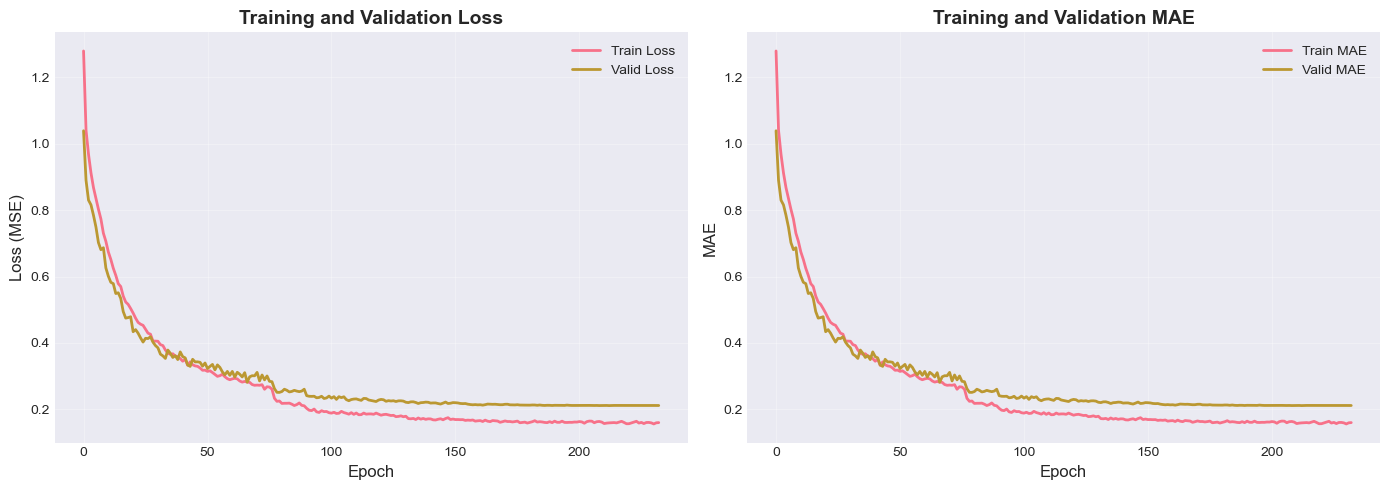

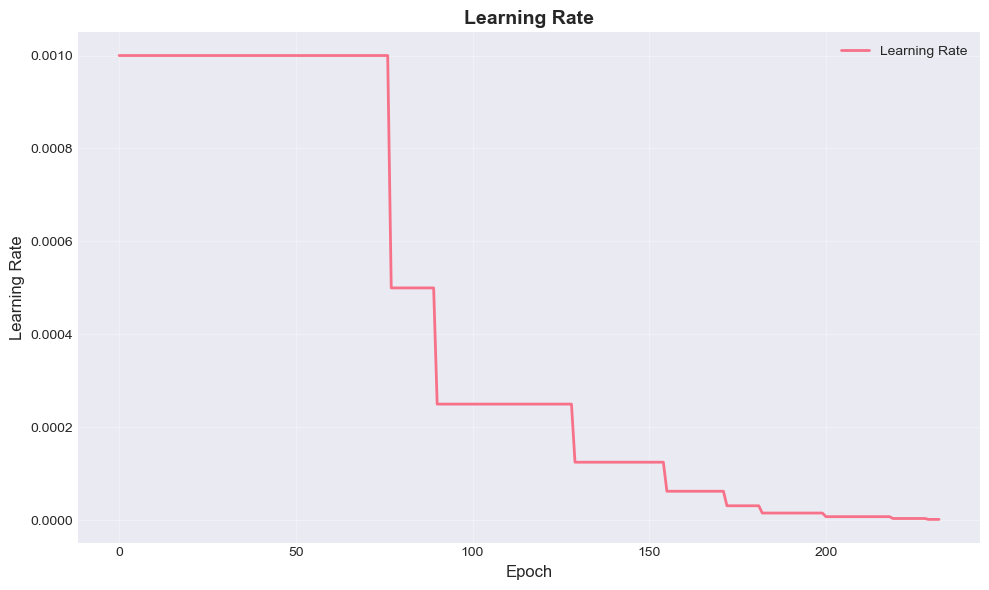

In [33]:
# 繪製訓練曲線
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Valid Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE curve
axes[1].plot(history.history['mse'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mse'], label='Valid MAE', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

# Learning Rate
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(history.history['lr'], label='Learning Rate', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Learning Rate', fontsize=12)
ax.set_title('Learning Rate', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / 'learning_rate.png', dpi=300, bbox_inches='tight')
plt.show()


In [34]:
# DNN 預測與評估
y_train_pred_dnn = dnn_model.predict(X_train_scaled).flatten()
y_valid_pred_dnn = dnn_model.predict(X_valid_scaled).flatten()
y_test_pred_dnn = dnn_model.predict(X_test_scaled).flatten()

# 反標準化預測結果
#y_train_pred_dnn = scaler_y.inverse_transform(y_train_pred_dnn_scaled.reshape(-1, 1)).flatten()
#y_valid_pred_dnn = scaler_y.inverse_transform(y_valid_pred_dnn_scaled.reshape(-1, 1)).flatten()
#y_test_pred_dnn = scaler_y.inverse_transform(y_test_pred_dnn_scaled.reshape(-1, 1)).flatten()

dnn_train_metrics = evaluate_model(y_train, y_train_pred_dnn, "DNN - Train")
dnn_valid_metrics = evaluate_model(y_valid, y_valid_pred_dnn, "DNN - Valid")
dnn_test_metrics = evaluate_model(y_test, y_test_pred_dnn, "DNN - Test")

116/116 [==============================] - 0s 1ms/step

DNN - Train - Performance Metrics
MAE  : 0.185321
RMSE : 0.257979
R²   : 0.947286

DNN - Valid - Performance Metrics
MAE  : 0.309593
RMSE : 0.459309
R²   : 0.837184

DNN - Test - Performance Metrics
MAE  : 0.320459
RMSE : 0.480669
R²   : 0.816340


## 7. 模型比較


Random Forest - All Data - Performance Metrics
MAE  : 0.348660
RMSE : 0.499952
R²   : 0.802700
  1/768 [..............................] - ETA: 19s

[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.0s finished


768/768 [==============================] - 1s 2ms/step

DNN - All Data - Performance Metrics
MAE  : 0.224234
RMSE : 0.335991
R²   : 0.910890

Complete Performance Comparison (All Datasets)
   Dataset         Model      MAE     RMSE       R²
  Training Random Forest 0.274657 0.374548 0.888886
  Training           DNN 0.185321 0.257979 0.947286
Validation Random Forest 0.525170 0.713432 0.607182
Validation           DNN 0.309593 0.459309 0.837184
      Test Random Forest 0.517483 0.708996 0.600415
      Test           DNN 0.320459 0.480669 0.816340
  All Data Random Forest 0.348660 0.499952 0.802700
  All Data           DNN 0.224234 0.335991 0.910890

Performance by Dataset

Training Set:
        Model      MAE     RMSE       R²
Random Forest 0.274657 0.374548 0.888886
          DNN 0.185321 0.257979 0.947286

Validation Set:
        Model      MAE     RMSE       R²
Random Forest 0.525170 0.713432 0.607182
          DNN 0.309593 0.459309 0.837184

Test Set:
        Model      MAE     RMS

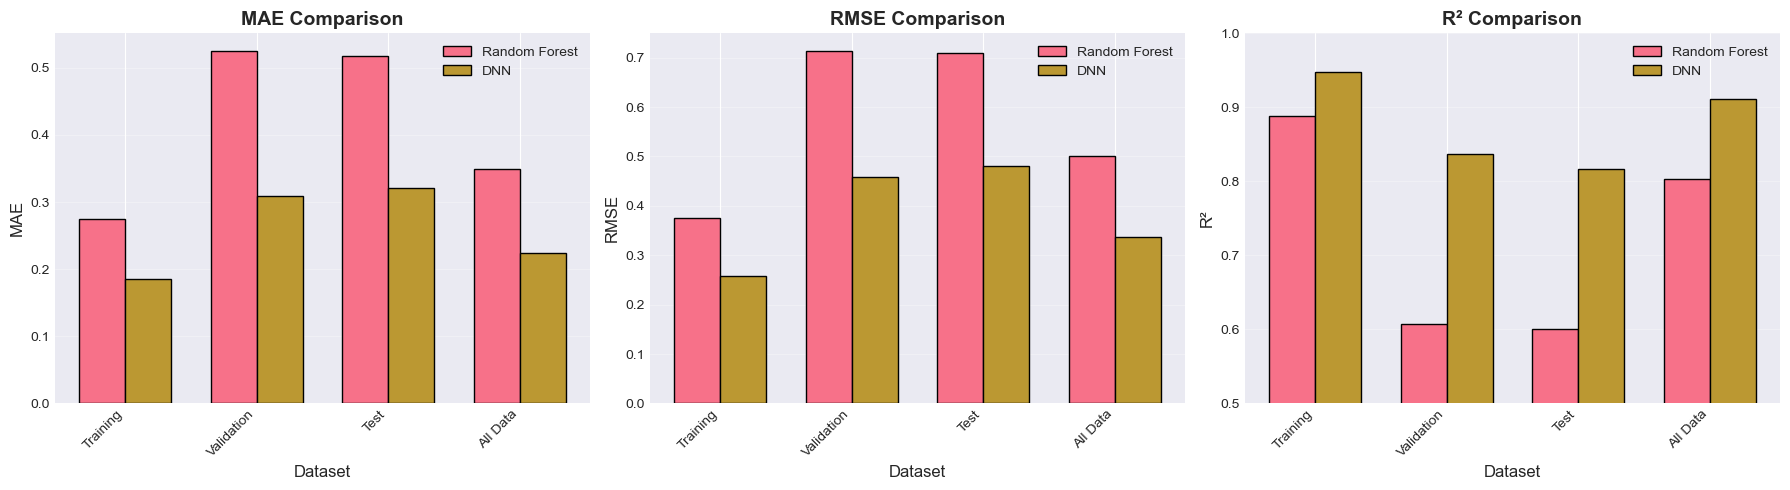


視覺化比較圖已保存至：outputs/P4_Unit15_Appendix_Mining/figs/model_comparison_all_datasets.png


In [35]:
# 建立完整比較表（包含 Train/Valid/Test 和 All Data）
y_all = pd.concat([y_train, y_valid, y_test])
X_all = pd.concat([X_train, X_valid, X_test])
X_all_scaled = scaler_X.transform(X_all)

# 計算所有數據集的性能
# Random Forest - All Data
y_all_pred_rf = rf_model.predict(X_all_scaled)
rf_all_metrics = evaluate_model(y_all, y_all_pred_rf, "Random Forest - All Data")

# DNN - All Data
y_all_pred_dnn = dnn_model.predict(X_all_scaled).flatten()
#y_all_pred_dnn = scaler_y.inverse_transform(y_all_pred_dnn_scaled.reshape(-1, 1)).flatten()
dnn_all_metrics = evaluate_model(y_all, y_all_pred_dnn, "DNN - All Data")

# 建立完整比較表
comparison_data = {
    'Dataset': ['Training', 'Training', 'Validation', 'Validation', 'Test', 'Test', 'All Data', 'All Data'],
    'Model': ['Random Forest', 'DNN', 'Random Forest', 'DNN', 'Random Forest', 'DNN', 'Random Forest', 'DNN'],
    'MAE': [
        rf_train_metrics['MAE'], dnn_train_metrics['MAE'],
        rf_valid_metrics['MAE'], dnn_valid_metrics['MAE'],
        rf_test_metrics['MAE'], dnn_test_metrics['MAE'],
        rf_all_metrics['MAE'], dnn_all_metrics['MAE']
    ],
    'RMSE': [
        rf_train_metrics['RMSE'], dnn_train_metrics['RMSE'],
        rf_valid_metrics['RMSE'], dnn_valid_metrics['RMSE'],
        rf_test_metrics['RMSE'], dnn_test_metrics['RMSE'],
        rf_all_metrics['RMSE'], dnn_all_metrics['RMSE']
    ],
    'R²': [
        rf_train_metrics['R2'], dnn_train_metrics['R2'],
        rf_valid_metrics['R2'], dnn_valid_metrics['R2'],
        rf_test_metrics['R2'], dnn_test_metrics['R2'],
        rf_all_metrics['R2'], dnn_all_metrics['R2']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("Complete Performance Comparison (All Datasets)")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# 按資料集分組顯示
print("\n" + "="*80)
print("Performance by Dataset")
print("="*80)
for dataset in ['Training', 'Validation', 'Test', 'All Data']:
    print(f"\n{dataset} Set:")
    subset = comparison_df[comparison_df['Dataset'] == dataset]
    print(subset[['Model', 'MAE', 'RMSE', 'R²']].to_string(index=False))

# Test Set 詳細比較（保留原有的改善幅度計算）
print("\n" + "="*80)
print("Test Set Detailed Comparison")
print("="*80)

# 計算改善幅度
mae_improvement = (rf_test_metrics['MAE'] - dnn_test_metrics['MAE']) / rf_test_metrics['MAE'] * 100
rmse_improvement = (rf_test_metrics['RMSE'] - dnn_test_metrics['RMSE']) / rf_test_metrics['RMSE'] * 100

print(f"\nDNN 相對於 Random Forest 的改善：")
print(f"MAE  改善：{mae_improvement:+.2f}%")
print(f"RMSE 改善：{rmse_improvement:+.2f}%")
print(f"R²   提升：{dnn_test_metrics['R2'] - rf_test_metrics['R2']:+.4f}")

# 視覺化比較
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

datasets = ['Training', 'Validation', 'Test', 'All Data']
x_pos = np.arange(len(datasets))
width = 0.35

# MAE comparison
rf_mae = [rf_train_metrics['MAE'], rf_valid_metrics['MAE'], rf_test_metrics['MAE'], rf_all_metrics['MAE']]
dnn_mae = [dnn_train_metrics['MAE'], dnn_valid_metrics['MAE'], dnn_test_metrics['MAE'], dnn_all_metrics['MAE']]

axes[0].bar(x_pos - width/2, rf_mae, width, label='Random Forest', edgecolor='black')
axes[0].bar(x_pos + width/2, dnn_mae, width, label='DNN', edgecolor='black')
axes[0].set_xlabel('Dataset', fontsize=12)
axes[0].set_ylabel('MAE', fontsize=12)
axes[0].set_title('MAE Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(datasets, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# RMSE comparison
rf_rmse = [rf_train_metrics['RMSE'], rf_valid_metrics['RMSE'], rf_test_metrics['RMSE'], rf_all_metrics['RMSE']]
dnn_rmse = [dnn_train_metrics['RMSE'], dnn_valid_metrics['RMSE'], dnn_test_metrics['RMSE'], dnn_all_metrics['RMSE']]

axes[1].bar(x_pos - width/2, rf_rmse, width, label='Random Forest', edgecolor='black')
axes[1].bar(x_pos + width/2, dnn_rmse, width, label='DNN', edgecolor='black')
axes[1].set_xlabel('Dataset', fontsize=12)
axes[1].set_ylabel('RMSE', fontsize=12)
axes[1].set_title('RMSE Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(datasets, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

# R² comparison
rf_r2 = [rf_train_metrics['R2'], rf_valid_metrics['R2'], rf_test_metrics['R2'], rf_all_metrics['R2']]
dnn_r2 = [dnn_train_metrics['R2'], dnn_valid_metrics['R2'], dnn_test_metrics['R2'], dnn_all_metrics['R2']]

axes[2].bar(x_pos - width/2, rf_r2, width, label='Random Forest', edgecolor='black')
axes[2].bar(x_pos + width/2, dnn_r2, width, label='DNN', edgecolor='black')
axes[2].set_xlabel('Dataset', fontsize=12)
axes[2].set_ylabel('R²', fontsize=12)
axes[2].set_title('R² Comparison', fontsize=14, fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(datasets, rotation=45, ha='right')
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_ylim([0.5, 1.0])  # 放大 R² 的差異

plt.tight_layout()
plt.savefig(FIG_DIR / 'model_comparison_all_datasets.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n視覺化比較圖已保存至：outputs/P4_Unit15_Appendix_Mining/figs/model_comparison_all_datasets.png")

## 8. 模型診斷圖

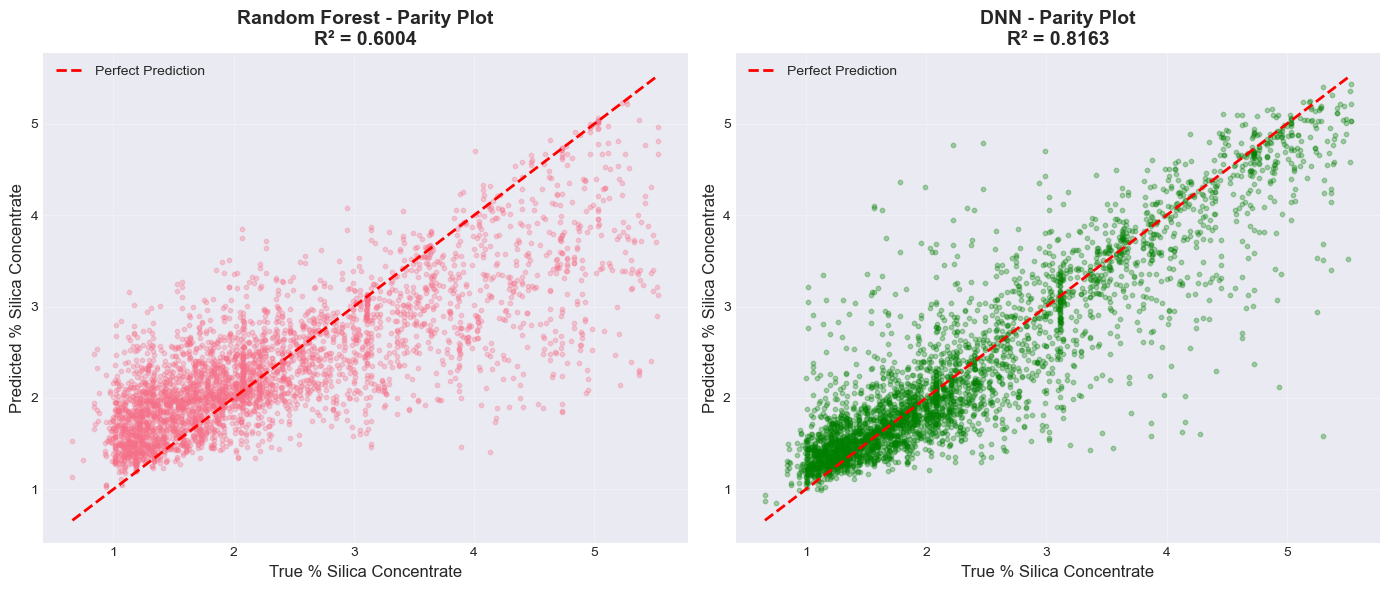

In [36]:
# Parity Plot（真值 vs 預測值）
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].scatter(y_test, y_test_pred_rf, alpha=0.3, s=10)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('True % Silica Concentrate', fontsize=12)
axes[0].set_ylabel('Predicted % Silica Concentrate', fontsize=12)
axes[0].set_title(f'Random Forest - Parity Plot\nR² = {rf_test_metrics["R2"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# DNN
axes[1].scatter(y_test, y_test_pred_dnn, alpha=0.3, s=10, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('True % Silica Concentrate', fontsize=12)
axes[1].set_ylabel('Predicted % Silica Concentrate', fontsize=12)
axes[1].set_title(f'DNN - Parity Plot\nR² = {dnn_test_metrics["R2"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'parity_plot.png', dpi=300, bbox_inches='tight')
plt.show()

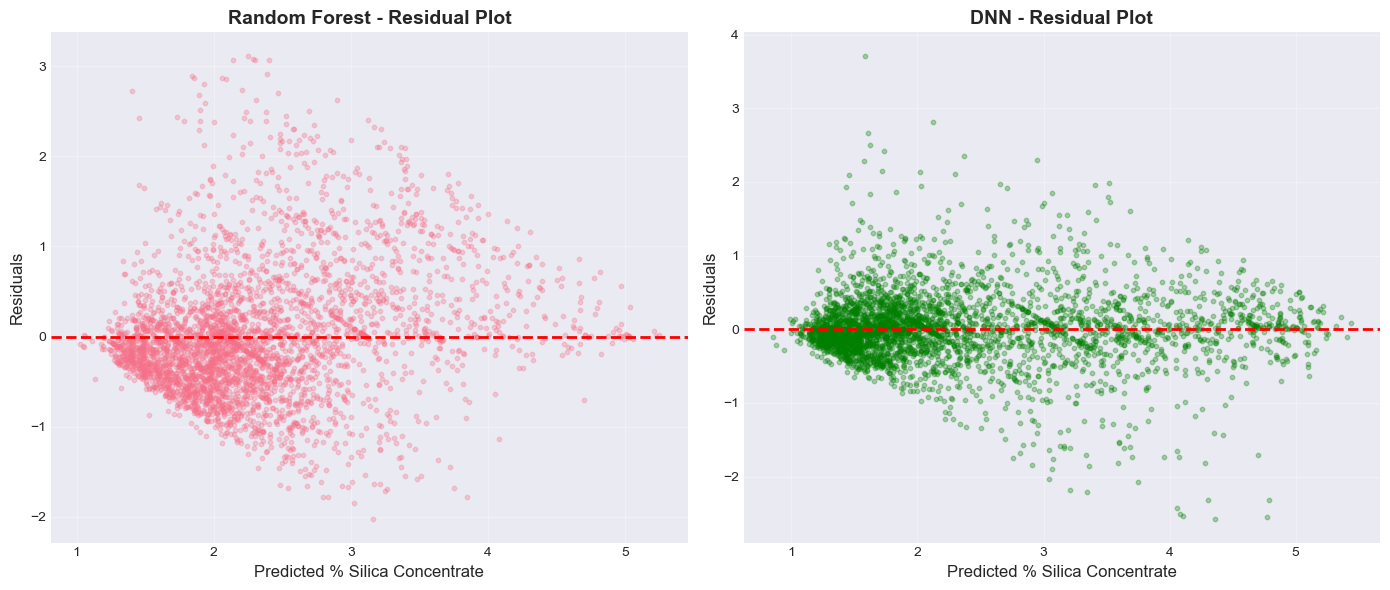

In [37]:
# Residual Plot（殘差圖）
residuals_rf = y_test - y_test_pred_rf
residuals_dnn = y_test - y_test_pred_dnn

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].scatter(y_test_pred_rf, residuals_rf, alpha=0.3, s=10)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted % Silica Concentrate', fontsize=12)
axes[0].set_ylabel('Residuals', fontsize=12)
axes[0].set_title('Random Forest - Residual Plot', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# DNN
axes[1].scatter(y_test_pred_dnn, residuals_dnn, alpha=0.3, s=10, color='green')
axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted % Silica Concentrate', fontsize=12)
axes[1].set_ylabel('Residuals', fontsize=12)
axes[1].set_title('DNN - Residual Plot', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'residual_plot.png', dpi=300, bbox_inches='tight')
plt.show()

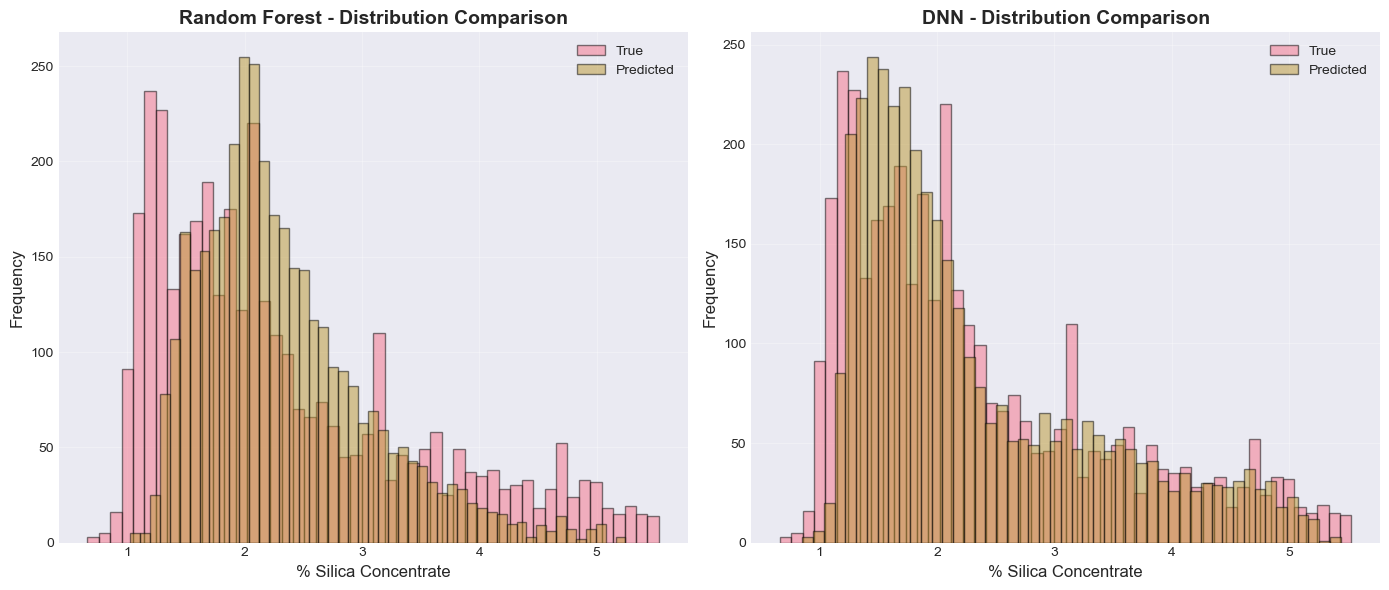

In [38]:
# 預測分佈比較
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].hist(y_test, bins=50, alpha=0.5, label='True', edgecolor='black')
axes[0].hist(y_test_pred_rf, bins=50, alpha=0.5, label='Predicted', edgecolor='black')
axes[0].set_xlabel('% Silica Concentrate', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Random Forest - Distribution Comparison', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# DNN
axes[1].hist(y_test, bins=50, alpha=0.5, label='True', edgecolor='black')
axes[1].hist(y_test_pred_dnn, bins=50, alpha=0.5, label='Predicted', edgecolor='black')
axes[1].set_xlabel('% Silica Concentrate', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('DNN - Distribution Comparison', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'test_true_vs_pred_dist.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. 特徵重要性分析

In [39]:
# Random Forest 特徵重要性（內建）
rf_feature_importance = pd.DataFrame({
    'Feature': X_shift.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest 特徵重要性（Top 15）：")
print(rf_feature_importance.head(15).to_string(index=False))

Random Forest 特徵重要性（Top 15）：
                          Feature  Importance
                       Amina Flow    0.055184
Flotation Column 03 Air Flow_lag6    0.023365
               % Silica Feed_lag6    0.021880
                 Ore Pulp pH_lag6    0.019181
                 % Iron Feed_lag6    0.018609
        Flotation Column 07 Level    0.017731
Flotation Column 04 Air Flow_lag6    0.015724
Flotation Column 04 Air Flow_lag5    0.014446
                  Amina Flow_lag1    0.013658
                      % Iron Feed    0.012912
                    % Silica Feed    0.012909
                      Ore Pulp pH    0.012800
                  Amina Flow_lag6    0.012563
Flotation Column 01 Air Flow_lag6    0.011910
        Flotation Column 03 Level    0.011435


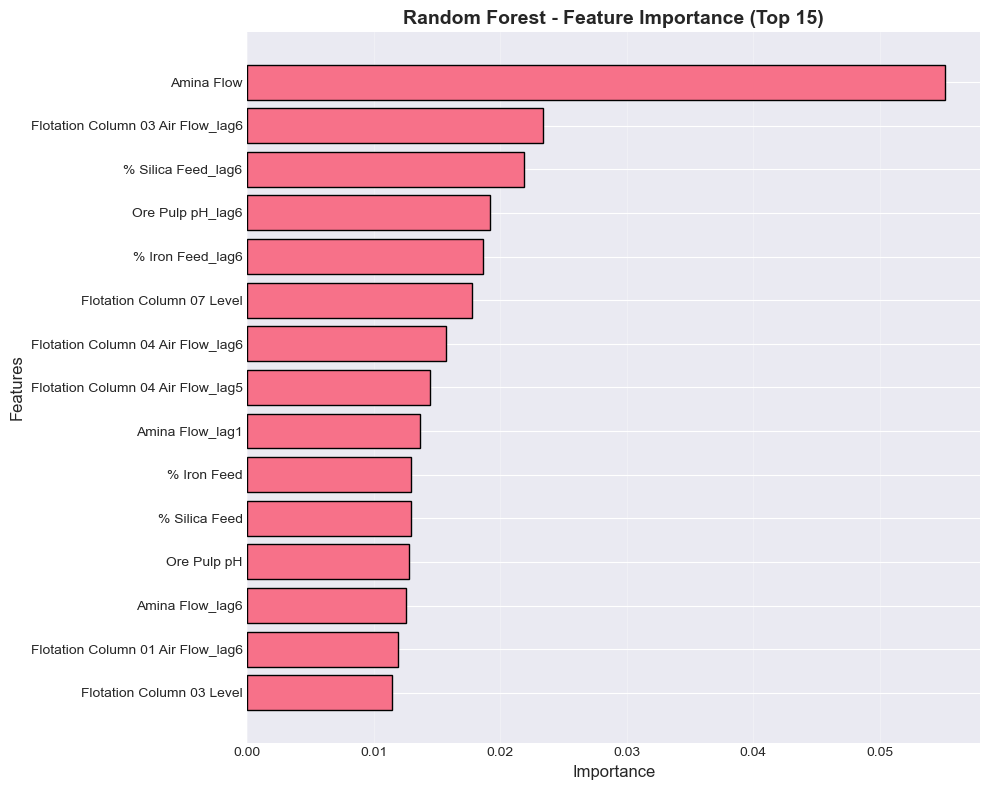

In [40]:
# 繪製 Random Forest 特徵重要性
fig, ax = plt.subplots(figsize=(10, 8))

top_15_rf = rf_feature_importance.head(15)
ax.barh(range(len(top_15_rf)), top_15_rf['Importance'], edgecolor='black')
ax.set_yticks(range(len(top_15_rf)))
ax.set_yticklabels(top_15_rf['Feature'])
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('Random Forest - Feature Importance (Top 15)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(FIG_DIR / 'rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# DNN Permutation Importance（在測試集上計算）
print("計算 DNN Permutation Importance...（這可能需要幾分鐘）")

# 為了加速，只使用測試集的一部分
sample_size = min(10000, len(X_test_scaled))
sample_indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)

X_test_sample = X_test_scaled[sample_indices]
y_test_sample = y_test.iloc[sample_indices]

# 定義 DNN 預測函數（sklearn 格式）
def dnn_predict(X_shift):
    return dnn_model.predict(X_shift, verbose=0).flatten()

# 計算 Permutation Importance
perm_importance = permutation_importance(
    dnn_model, X_test_sample, y_test_sample,
    n_repeats=10,
    random_state=SEED,
    scoring='neg_mean_absolute_error'
)

dnn_feature_importance = pd.DataFrame({
    'Feature': X_shift.columns,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

print("\nDNN Permutation Importance（Top 15）：")
print(dnn_feature_importance.head(15).to_string(index=False))

計算 DNN Permutation Importance...（這可能需要幾分鐘）
116/116 [==============================] - 0s 2ms/step

DNN Permutation Importance（Top 15）：
                       Feature  Importance
                    Amina Flow    0.095991
                   Ore Pulp pH    0.070694
            % Silica Feed_lag6    0.068143
              Ore Pulp pH_lag6    0.053757
              Ore Pulp Density    0.048824
               Amina Flow_lag6    0.047444
               Amina Flow_lag1    0.038519
Flotation Column 03 Level_lag6    0.038274
     Flotation Column 01 Level    0.034030
            % Silica Feed_lag5    0.031613
     Flotation Column 03 Level    0.031230
         Ore Pulp Density_lag6    0.029526
              % Iron Feed_lag6    0.027217
               Amina Flow_lag3    0.025561
               Amina Flow_lag2    0.025335


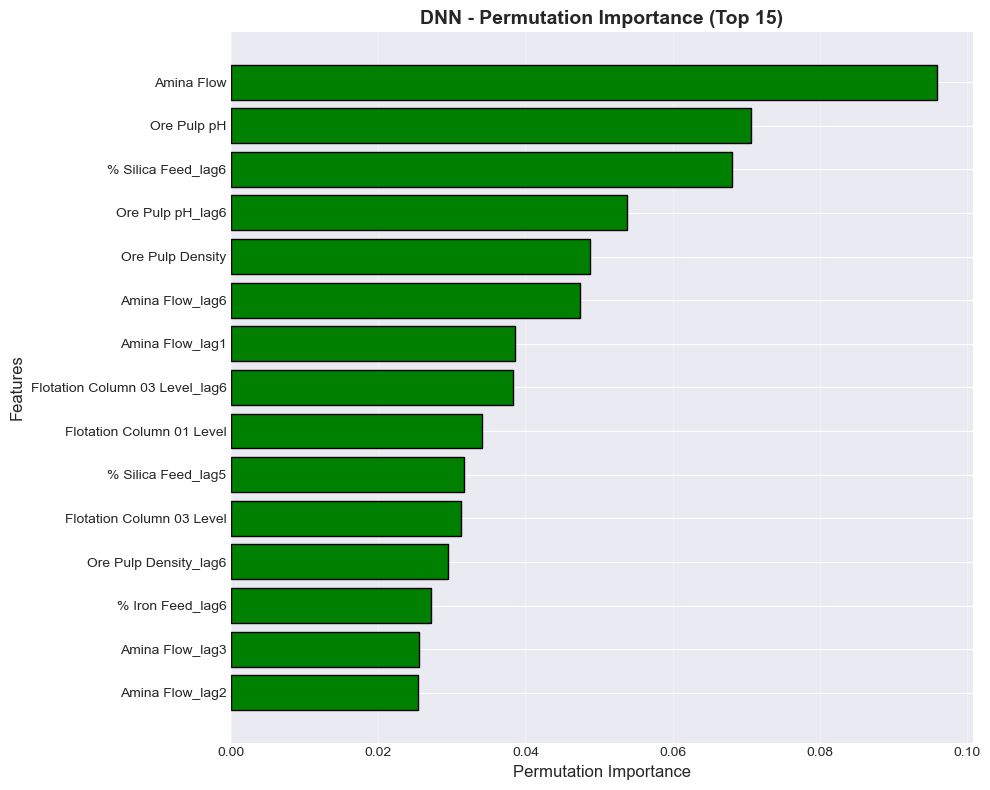

In [42]:
# 繪製 DNN Permutation Importance
fig, ax = plt.subplots(figsize=(10, 8))

top_15_dnn = dnn_feature_importance.head(15)
ax.barh(range(len(top_15_dnn)), top_15_dnn['Importance'], color='green', edgecolor='black')
ax.set_yticks(range(len(top_15_dnn)))
ax.set_yticklabels(top_15_dnn['Feature'])
ax.set_xlabel('Permutation Importance', fontsize=12)
ax.set_ylabel('Features', fontsize=12)
ax.set_title('DNN - Permutation Importance (Top 15)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(FIG_DIR / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. 模型保存

In [43]:
import joblib
# 保存 DNN 模型
dnn_model.save(MODEL_DIR / 'final_dnn_model.h5')
print(f"DNN 模型已保存至：{MODEL_DIR / 'final_dnn_model.h5'}")
joblib.dump(history.history, MODEL_DIR / 'dnn_training_history.joblib')
print(f"DNN 模型訓練歷史已保存至：{MODEL_DIR / 'dnn_training_history.joblib'}")

# 保存 Random Forest 模型
joblib.dump(rf_model, MODEL_DIR / 'rf_model.joblib')
print(f"Random Forest 模型已保存至：{MODEL_DIR / 'rf_model.joblib'}")

# 保存 Scaler
joblib.dump(scaler_X, MODEL_DIR / 'scaler_X.joblib')
joblib.dump(scaler_y, MODEL_DIR / 'scaler_y.joblib')
print(f"Scaler_y 已保存至：{MODEL_DIR / 'scaler_y.joblib'}")
print(f"Scaler 已保存至：{MODEL_DIR / 'scaler_X.joblib'}")

DNN 模型已保存至：d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Mining\models\final_dnn_model.h5
DNN 模型訓練歷史已保存至：d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Mining\models\dnn_training_history.joblib
Random Forest 模型已保存至：d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Mining\models\rf_model.joblib
Scaler_y 已保存至：d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Mining\models\scaler_y.joblib
Scaler 已保存至：d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Mining\models\scaler_X.joblib


In [44]:
# 保存完整結果摘要（包含所有數據集的比較）
import json
results_summary = {
    'Model_Comparison': {
        'Training': {
            'Random Forest': {'MAE': rf_train_metrics['MAE'], 'RMSE': rf_train_metrics['RMSE'], 'R2': rf_train_metrics['R2']},
            'DNN': {'MAE': dnn_train_metrics['MAE'], 'RMSE': dnn_train_metrics['RMSE'], 'R2': dnn_train_metrics['R2']}
        },
        'Validation': {
            'Random Forest': {'MAE': rf_valid_metrics['MAE'], 'RMSE': rf_valid_metrics['RMSE'], 'R2': rf_valid_metrics['R2']},
            'DNN': {'MAE': dnn_valid_metrics['MAE'], 'RMSE': dnn_valid_metrics['RMSE'], 'R2': dnn_valid_metrics['R2']}
        },
        'Test': {
            'Random Forest': {'MAE': rf_test_metrics['MAE'], 'RMSE': rf_test_metrics['RMSE'], 'R2': rf_test_metrics['R2']},
            'DNN': {'MAE': dnn_test_metrics['MAE'], 'RMSE': dnn_test_metrics['RMSE'], 'R2': dnn_test_metrics['R2']}
        },
        'All_Data': {
            'Random Forest': {'MAE': rf_all_metrics['MAE'], 'RMSE': rf_all_metrics['RMSE'], 'R2': rf_all_metrics['R2']},
            'DNN': {'MAE': dnn_all_metrics['MAE'], 'RMSE': dnn_all_metrics['RMSE'], 'R2': dnn_all_metrics['R2']}
        }
    },
    'Test_Set_Improvement': {
        'MAE_improvement_percent': mae_improvement,
        'RMSE_improvement_percent': rmse_improvement,
        'R2_difference': dnn_test_metrics['R2'] - rf_test_metrics['R2']
    },
    'Comparison_DataFrame': comparison_df.to_dict('records')  # 將 DataFrame 轉為字典列表
}

# 保存為 JSON
with open(MODEL_DIR / 'results_summary.json', 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=4, ensure_ascii=False)

print(f"\n完整結果摘要已保存至：{MODEL_DIR / 'results_summary.json'}")
print("\n包含內容：")
print("  - Model_Comparison: 所有數據集（Training/Validation/Test/All Data）的性能指標")
print("  - Test_Set_Improvement: Test Set 的改善幅度")
print("  - Comparison_DataFrame: 完整比較表（8 行數據）")


完整結果摘要已保存至：d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Mining\models\results_summary.json

包含內容：
  - Model_Comparison: 所有數據集（Training/Validation/Test/All Data）的性能指標
  - Test_Set_Improvement: Test Set 的改善幅度
  - Comparison_DataFrame: 完整比較表（8 行數據）


## 11. 總結

本 Notebook 展示了完整的 DNN 建模流程：

1. **資料預處理**：處理缺失值、資料切分、標準化
2. **EDA**：目標分佈、相關性分析、特徵探索
3. **Baseline 模型**：Random Forest 作為強 Baseline
4. **DNN 建模**：架構設計、訓練、優化
5. **模型評估**：Parity plot、Residual plot、性能比較
6. **特徵重要性**：Random Forest 內建重要性、DNN Permutation Importance

**關鍵發現**：
- DNN 在此案例中相對於 Random Forest 有顯著改善
- 原礦品質（% Silica Feed, % Iron Feed）是最重要的決定因素
- 藥劑流量與浮選柱操作變數的效果存在非線性關係

**實務建議**：
- 需要定期重新訓練模型以適應原礦品質變化
- 可考慮使用時序模型（LSTM/GRU）捕捉動態特性
- 部署時需考慮感測器故障、缺失值處理等問題